In [1]:
import os
from pathlib import Path

from ansys.heart.misc.downloader import download_case, unpack_case
import ansys.heart.preprocessor.models as models

import pyvista
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation

from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform

os.environ["USE_OLD_HEART_MODELS"] = "1"

__file__ = r"c:\Users\xuhu\pyheart-lib\examples\preprocessor\doc_ECG_coordinates,py"

case_file = str(
    Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", "01", "01.case")
)
download_folder = str(Path(Path(__file__).resolve().parents[2], "downloads"))
workdir = str(
    Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", "01", "Biv")
)
path_to_model = str(Path(workdir, "heart_model.pickle"))


if not os.path.isfile(case_file):
    path_to_downloaded_file = download_case(
        "Strocchi2020", 1, download_folder=download_folder, overwrite=False
    )
    unpack_case(path_to_downloaded_file)


info = models.ModelInfo(
    database="Strocchi2020",
    path_to_case=case_file,
    work_directory=workdir,
    path_to_model=path_to_model,
    add_blood_pool=False,
    mesh_size=1.5,
)


# create the working directory
info.create_workdir()
# clean the working directory
info.clean_workdir(extensions_to_remove=[".stl", ".vtk", ".msh.h5"])
# dump information to stdout
info.dump_info()

# instantiate a four chamber model
model = models.BiVentricle(info)

# extract the simulation mesh
model.extract_simulation_mesh()

# dump the model to disk for future use
model.dump_model(path_to_model)
# print the resulting information
model.print_info()

2023/11/03 14:09:33 - DEBUG - Establishing tetra-face connectivity...
2023/11/03 14:10:03 - DEBUG - Time elapsed: 30.0 s
2023/11/03 14:10:03 - DEBUG - Skipping interface pair: Left ventricle myocardium | Right ventricle myocardium
2023/11/03 14:10:04 - DEBUG - Extracting : ['epicardium', 'endocardium', 'septum'] from left-ventricle-myocardium
2023/11/03 14:10:05 - DEBUG - Extracting : ['epicardium', 'endocardium'] from right-ventricle-myocardium
2023/11/03 14:10:07 - INFO - Remeshing volume...
c:\ProgramData\miniforge3\envs\env38\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.17) or chardet (None)/charset_normalizer (3.3.1) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
2023/11/03 14:10:11 - DEBUG - Starting meshing in directory: C:\Users\xuhu\pyheart-lib\downloads\Strocchi2020\01\Biv\meshing



Importing one geom object per program-controlled and one zone per body ...
    C:\\Program Files\\ANSYS Inc\\v222\\commonfiles\\CPython\\3_7\\winx64\\Release\\python\\..\\Ansys\\TGrid\\CADReaders.py started by xuhu on LYOTRAINEE14 winx64 on Fri Nov  3 14:10:43 2023
    using Python 3.7.13 (remotes/origin/bdighole/python/3713/clean_up-dirty:d4e1bece, Apr  6 2022, 00:24:) [MSC v.1920 64 bit (AMD64)]
    
    using Ansys.Meshing.FieldMesher build May 27 2022 08:47:51
    
    running ANSYS TGrid CADToTGridConverter ...
    setting up parameters ...
    setting up parameters done.
    running conversion ...
    converting 9 file(s) from Workbench to FLTG using output path 'C:\\Users\\xuhu\\AppData\\Local\\Temp/out169901704227560.tgf'
    converting file 'part_left-ventricle-endocardium.stl' (1 of 9) from Workbench to FLTG using output path 'C:\\Users\\xuhu\\AppData\\Local\\Temp'
    importing data ...
    importing meshing model in STL format from file 'C:\\Users\\xuhu\\pyheart-lib\\downl

2023/11/03 14:11:36 - DEBUG - Excluding 4 array names
2023/11/03 14:11:37 - DEBUG - Removing cell data...uvc_intraventricular
2023/11/03 14:11:37 - DEBUG - Removing cell data...uvc_longitudinal
2023/11/03 14:11:37 - DEBUG - Removing cell data...uvc_rotational
2023/11/03 14:11:37 - DEBUG - Removing cell data...uvc_transmural
2023/11/03 14:11:37 - WARNING - Normalization of vectors is buggy and turned off
2023/11/03 14:11:37 - WARNING - Removed returning cell / point data
2023/11/03 14:11:42 - DEBUG - Excluding 5 array names
2023/11/03 14:11:42 - DEBUG - Removing cell data...electrode_endo_rv
2023/11/03 14:11:42 - DEBUG - Removing cell data...uvc_intraventricular
2023/11/03 14:11:42 - DEBUG - Removing cell data...uvc_longitudinal
2023/11/03 14:11:42 - DEBUG - Removing cell data...uvc_rotational
2023/11/03 14:11:42 - DEBUG - Removing cell data...uvc_transmural
2023/11/03 14:11:42 - DEBUG - Removing point data...fiber
2023/11/03 14:11:42 - DEBUG - Removing point data...sheet
2023/11/03 14:

In [9]:
# Extract cap centroids from the left and right ventricles
fix_points = [cap.centroid for cap in model.left_ventricle.caps]
fix_points += [cap.centroid for cap in model.right_ventricle.caps]

# Extract apex coordinates from the left and right ventricles
fix_points += [apex.xyz for apex in model.left_ventricle.apex_points]
fix_points += [apex.xyz for apex in model.right_ventricle.apex_points]

# Convert the list of points to a NumPy array
fix_points = np.array(fix_points)
fix_points

array([[  4.12941494, 118.29649081, 391.32786014],
       [ 14.98680954, 139.00226196, 381.86715647],
       [ 11.87729029,  95.81072653, 423.85163788],
       [-22.98193342,  92.93539604, 363.03716106],
       [ 66.92678229,  76.22910099, 352.55582004],
       [ 70.06069878,  71.27226575, 353.05062963],
       [ 45.41901794,  78.01370688, 333.33936308],
       [ 47.67597045,  76.44610331, 331.14411229]])

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


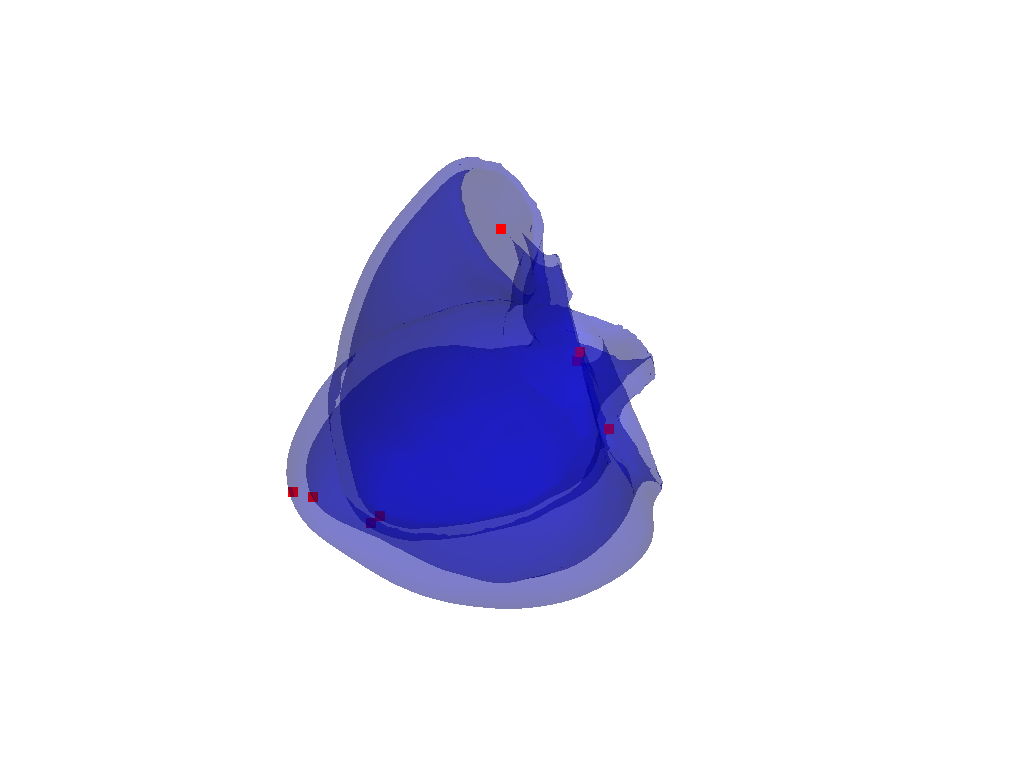

In [10]:
plotter = pyvista.Plotter()
plotter.add_mesh(fix_points, color="red", point_size=10)
plotter.add_mesh(model.mesh, color="blue", opacity=0.3)
plotter.background_color = "white"
plotter.show()

## Visualization of the Moving Heart Model (Before Registration)
The PyVista plotter displays the initial state of the "moving" heart model, along with valve centroids, apex positions, and electrode positions.

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


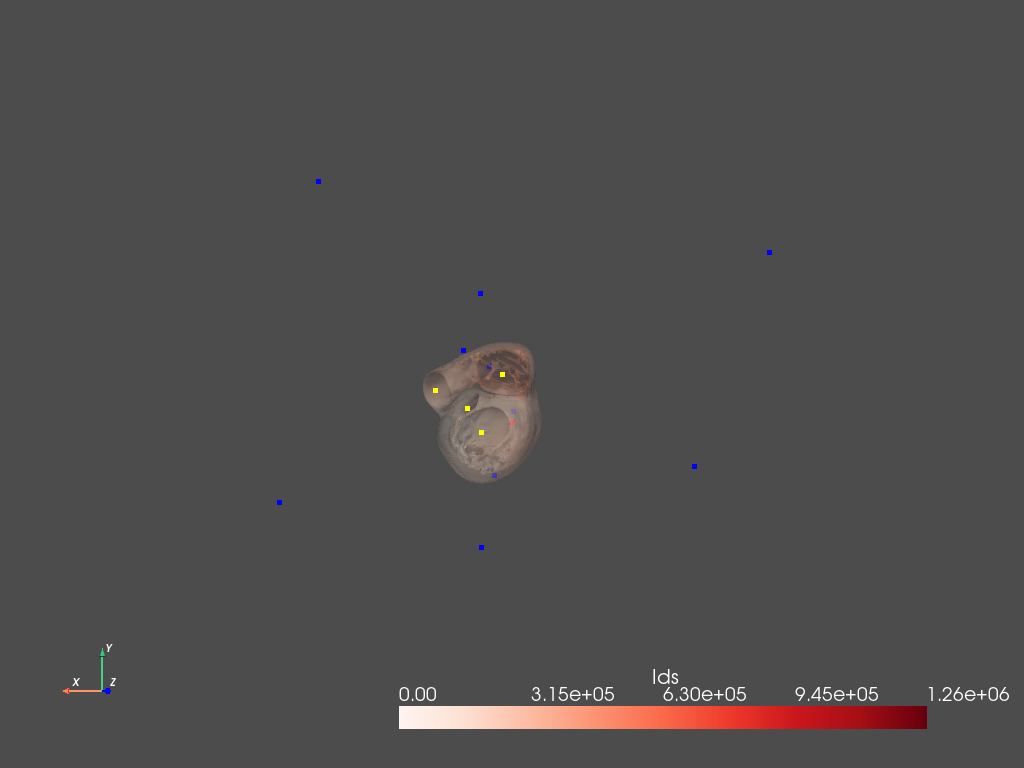

In [54]:
# show all auxiliary points
plotter = pyvista.Plotter()

valve_centroid_positions = np.array([
    [x, y, z] for x, y, z in [
        [81.90321388, 57.90000882, 205.76663367], 
        [94.35242091, 75.99022315, 213.31654731], 
        [67.14045655, 102.49380179, 216.20654707],
        [121.58912558, 89.76497459, 223.29557159]
    ]
])

apex_endo_positions = np.array([
    [x, y, z] for x, y, z in [
        [67.23725112873248, 84.63169515538843, 296.5102709741695], 
        [74.54353173118157, 63.020954005473115, 302.25073384261583]
    ]
])

plotter.add_mesh(heart, cmap="Reds", opacity=0.3)
plotter.add_mesh(valve_centroid_positions, color="yellow", point_size=5)
plotter.add_mesh(apex_endo_positions, color="red", point_size=5)
plotter.add_mesh(electrode_positions, color="blue", point_size=5)

plotter.camera_position = 'xy'
plotter.camera.azimuth = 190.0

plotter.show_axes()
plotter.show()

# For each method, the assessment of its quality involves the use of the MSD, HD, SO as a metric.

## Mean Surface Distance:
**Definition**: The mean surface distance is the average distance between each point on the surfaces of two models.
Interpretation: A smaller mean surface distance indicates that the surfaces of the two models are closer, suggesting that the registration result is generally accurate. If the mean surface distance is large, it may indicate significant deviations in certain areas.

## Hausdorff Distance:
**Definition**: The Hausdorff distance is the maximum distance between points on the surfaces of two models, representing the maximum inconsistency between the two models.
Interpretation: A smaller Hausdorff distance indicates a good overall match, but Hausdorff distance is sensitive to outliers. If there are local inconsistencies, the Hausdorff distance may increase.

## Surface Overlap:
**Definition**: Surface overlap is the proportion of the overlap region on the surfaces of two models to the total surface area.
Interpretation: A higher surface overlap indicates significant overlap on the surfaces, meaning that the registration result is a good overall match. If the surface overlap is low, it may indicate that some parts of the models are not correctly aligned or matched.
Considering the comprehensive analysis of these three indicators, the following conclusions can be drawn:

If the **MSD** is small, **HD** is small, and **SO** is high, then the registration result is ideal.

In [11]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

def downsample_points(points, target_size):
    indices = np.random.choice(len(points), target_size, replace=False)
    return points[indices]

# calculate MES, HD and SO
def evaluate_mesh_similarity(transformed_model, original_model):
    # Extract points from the mesh vertices
    points_transformed = transformed_model.points
    points_original = original_model.mesh.points

    # Downsample points if the sizes are different
    if len(points_transformed) > len(points_original):
        points_transformed = downsample_points(points_transformed, len(points_original))
    elif len(points_original) > len(points_transformed):
        points_original = downsample_points(points_original, len(points_transformed))

    # Compute the Hausdorff distance
    hausdorff_distance = directed_hausdorff(points_transformed, points_original)[0]

    # Compute Mean Surface Distance
    mean_surface_distance = np.mean(np.linalg.norm(points_transformed - points_original, axis=1))

    # Estimate Surface Overlap based on volume intersection
    volume_intersection = np.sum(np.minimum(points_transformed[:, 2], points_original[:, 2]))
    volume_union = np.sum(points_transformed[:, 2]) + np.sum(points_original[:, 2]) - volume_intersection
    surface_overlap = volume_intersection / volume_union

    # Output the results
    print(f'Mean Surface Distance: {mean_surface_distance}')
    print(f'Hausdorff Distance: {hausdorff_distance}')
    print(f'Surface Overlap: {surface_overlap}')


# ex: mesh similarity on rigid transformation with scipy
# evaluate_mesh_similarity(transformed_model, model)
# outcome:
# Mean Surface Distance: 61.7619445333858
# Hausdorff Distance: 26.272064126730633
# Surface Overlap: 0.9249680448917617


### Define fixed model and moving model
- fixed: strocchi model
- moving: heart template

In [13]:
# read template torso file
file_path = r"C:\Users\xuhu\Downloads\2019_Lopez_torsoPAP_tetraVol-Labeled.vtk\torsoPAP_tetraVol-Labeled_ORIGINAL_full.vtk"
torso = pyvista.read(file_path)

Organids_array = torso["OrganID"]
organ_id_to_plot = 7
# ribs = torso.threshold([organ_id_to_plot - 0.1, organ_id_to_plot + 0.1], scalars="OrganID")
heart = torso.threshold([organ_id_to_plot - 0.1, organ_id_to_plot + 0.1], scalars="OrganID")

In [24]:
# --------------------------Use rigid transform--------------------------

"""
fixed_points: obtained by BiV

mitral-valve [ 14.78575795 138.72218537 381.66334608]
aortic-valve [  4.20356264 118.41931813 391.46262272]
tricuspid-valve [-23.12532785  92.6664522  363.28210652]
pulmonary-valve [ 11.8208042   95.51631782 424.01633795]
left_ventricle apex:  [ 66.98953175  76.04045288 353.25812367]
left_ventricle apex:  [ 70.91348565  72.35403913 352.7457911 ]
right_ventricle apex:  [ 45.9829824   77.48032215 333.94426975]
right_ventricle apex:  [ 47.77539122  77.14911944 331.0164472 ]
"""

move_points = np.array([
    [94.35242091, 75.99022315, 213.31654731], # aortic-valve
    [81.90321388, 57.90000882, 205.76663367], # mitral-valve 
    [121.58912558, 89.76497459, 223.29557159], # pulmonary-valve
    [67.14045655, 102.49380179, 216.20654707], # tricuspid-valve
    [70.87069056682236, 84.83837198547876, 295.6765864478138], # left endo
    [70.54655746919204, 84.50457846174797, 297.2737993295601], # left epi
    [76.04229182019685, 66.53094359081156, 297.7182142431582], # right endo
    [75.08606835375224, 66.33759424571653, 302.2811669120656], # right epi   
])

fix_cloud = pyvista.PolyData(fix_points)
move_cloud = pyvista.PolyData(move_points)

moving_model = heart

## Rigid trans with scipy

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


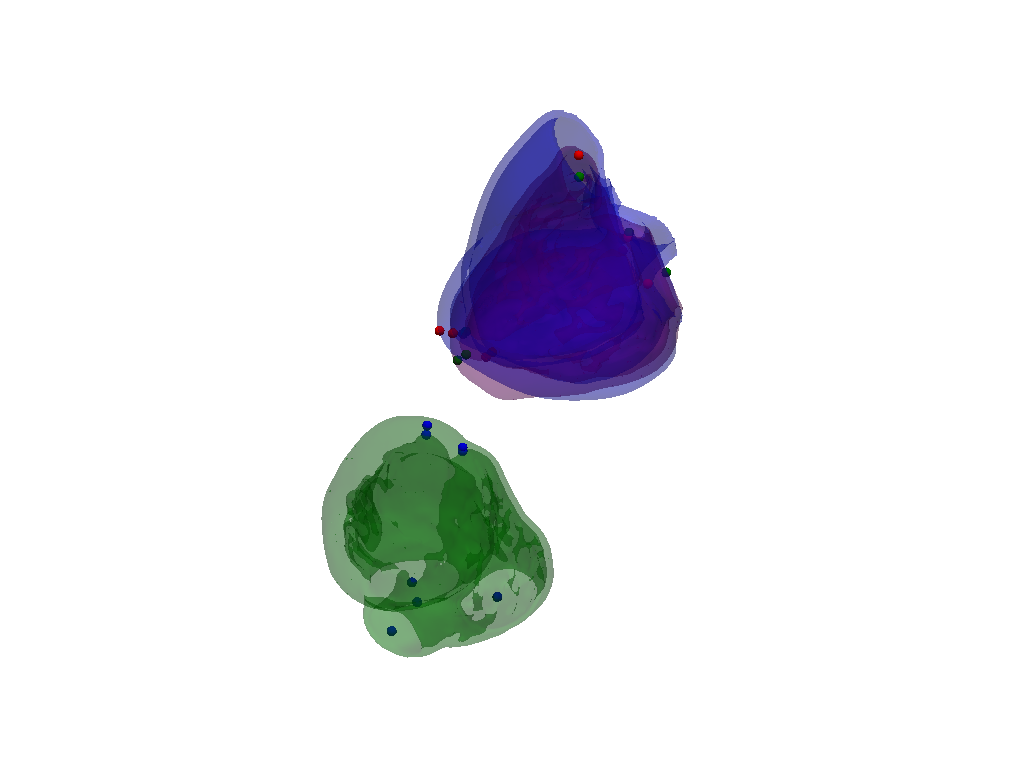

In [23]:
# Define the initial transformation parameters
random_quaternion = Rotation.random().as_quat()
initial_params = np.zeros(7)
initial_params[:3] = np.random.rand(3)  # Random translation
initial_params[3:] = random_quaternion

# Constrain quaternion components
constraints = ({'type': 'eq', 'fun': lambda params: 1.0 - np.sum(params[3:] ** 2)})

# rigid transform function
def rigid_transform(params, points):
    translation = params[:3]
    quaternion = params[3:]
    quaternion /= np.linalg.norm(quaternion)
    rotation_matrix = Rotation.from_quat(quaternion).as_matrix()
    transformed_points = np.dot(points - translation, rotation_matrix.T)
    return transformed_points

# function to calculate the optimized parameter
def objective_function(params, fixed_points, moving_points):
    transformed_points = rigid_transform(params, moving_points)
    distance = np.sum(np.square(transformed_points - fixed_points))
    return distance

# Get the optimized parameters
result = minimize(
    objective_function, 
    initial_params, 
    args=(fix_points, move_points), 
    method='L-BFGS-B', 
    constraints=constraints)
optimal_params = result.x

transformed_move_points = rigid_transform(optimal_params, move_points)
transformed_move_cloud = pyvista.PolyData(transformed_move_points)

# --------------- Registeration ---------------
transformed_model = moving_model.copy()
transformed_model.points = rigid_transform(optimal_params, moving_model.points)

# --------------- Visualization ---------------
# Strocchi heart: blue
# Original template heart: green
# Transformed template heart: purple
plotter = pyvista.Plotter()
plotter.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
plotter.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
plotter.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)

plotter.add_mesh(moving_model, color="green", opacity=0.3)
plotter.add_mesh(transformed_model, color="purple", opacity=0.3)
plotter.add_mesh(model.mesh, color="blue", opacity=0.3)

plotter.background_color = "white"
plotter.show()

In [26]:
# Evaluation
evaluate_mesh_similarity(transformed_model, model)

Mean Surface Distance: 61.57116004297041
Hausdorff Distance: 25.194861600225266
Surface Overlap: 0.9249579160663406


## GetLandmarkTransform

In [27]:
def vtkpoints_to_numpy(vtk_points):
    """Convert VTK vtkPoints to NumPy array."""
    num_points = vtk_points.GetNumberOfPoints()
    points_array = np.empty((num_points, 3))

    for i in range(num_points):
        point = vtk_points.GetPoint(i)
        points_array[i] = point

    return points_array

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


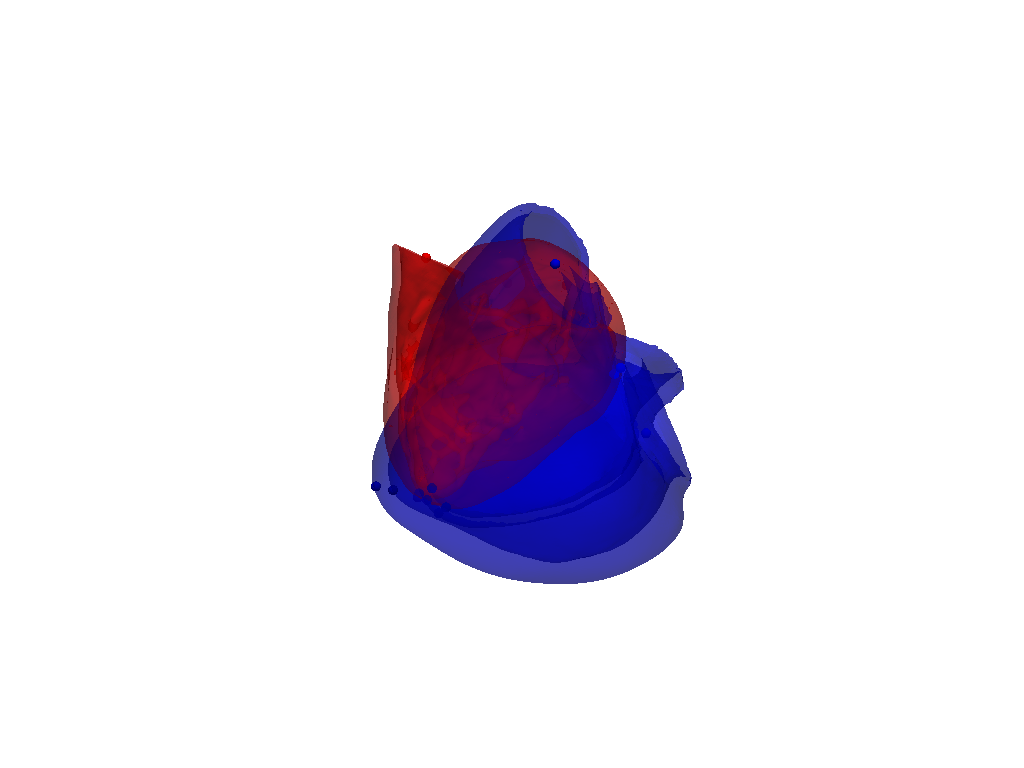

In [28]:
import pyvista as pv
from vtk import vtkLandmarkTransform, vtkPoints, vtkTransform

fix_cloud = pv.PolyData(fix_points)
move_cloud = pv.PolyData(move_points)

# p = pv.Plotter()
# p.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p.add_mesh(model.mesh, color="red", opacity=0.3)
# p.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p.add_mesh(heart, color="blue", opacity=0.3)
# p.show()

fix_vtk_points = vtkPoints()
for point in fix_points:
    fix_vtk_points.InsertNextPoint(point)

move_vtk_points = vtkPoints()
for point in move_points:
    move_vtk_points.InsertNextPoint(point)

"""
establish the mapping relationship between the two spaces
vtkLandmarkTransform facilitates mapping points 
between spaces based on 
user-defined landmark correspondences
"""
landmark_transform = vtkLandmarkTransform()
landmark_transform.SetSourceLandmarks(fix_vtk_points)
landmark_transform.SetTargetLandmarks(move_vtk_points)
landmark_transform.SetModeToRigidBody()
landmark_transform.Update()

matrix = landmark_transform.GetMatrix()

vtk_transform = vtkTransform()
vtk_transform.SetMatrix(matrix)

transformed_move_cloud = move_cloud.copy()
transformed_move_cloud.transform(vtk_transform)


moving_model = heart.copy()

moving_model.transform(vtk_transform)

p2 = pv.Plotter()

p2.add_mesh(fix_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(moving_model, color="red", opacity=0.5)
p2.add_mesh(model.mesh, color="blue", opacity=0.5)

p2.background_color = "white"

p2.show()

In [29]:
evaluate_mesh_similarity(moving_model, model)

Mean Surface Distance: 89.43657944743664
Hausdorff Distance: 55.882467876602306
Surface Overlap: 0.907955631269939


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


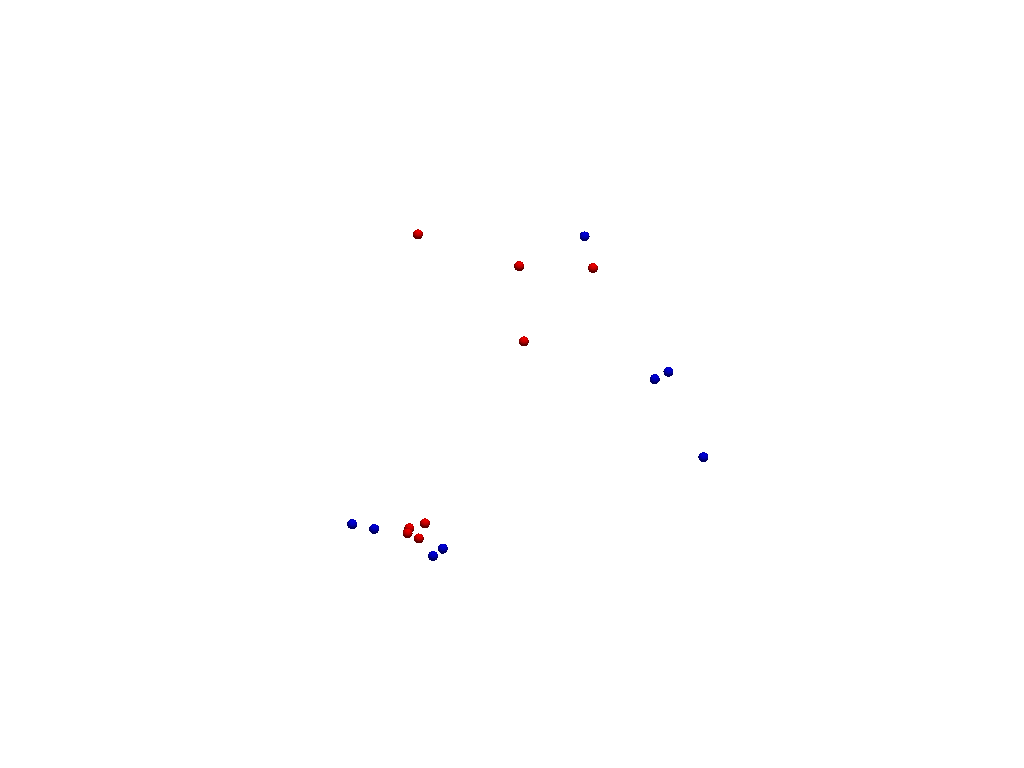

In [21]:
p2 = pv.Plotter()

p2.add_mesh(fix_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.background_color = "white"

p2.show()

## Non rigid transform with landmark
#### **Rigid**: rotation + translation

#### **Similarity**: rigid + isotropic scaling

#### **Affine**: rigid + scaling + shear

### SetModeToSimilarity
affine: on point clouds

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


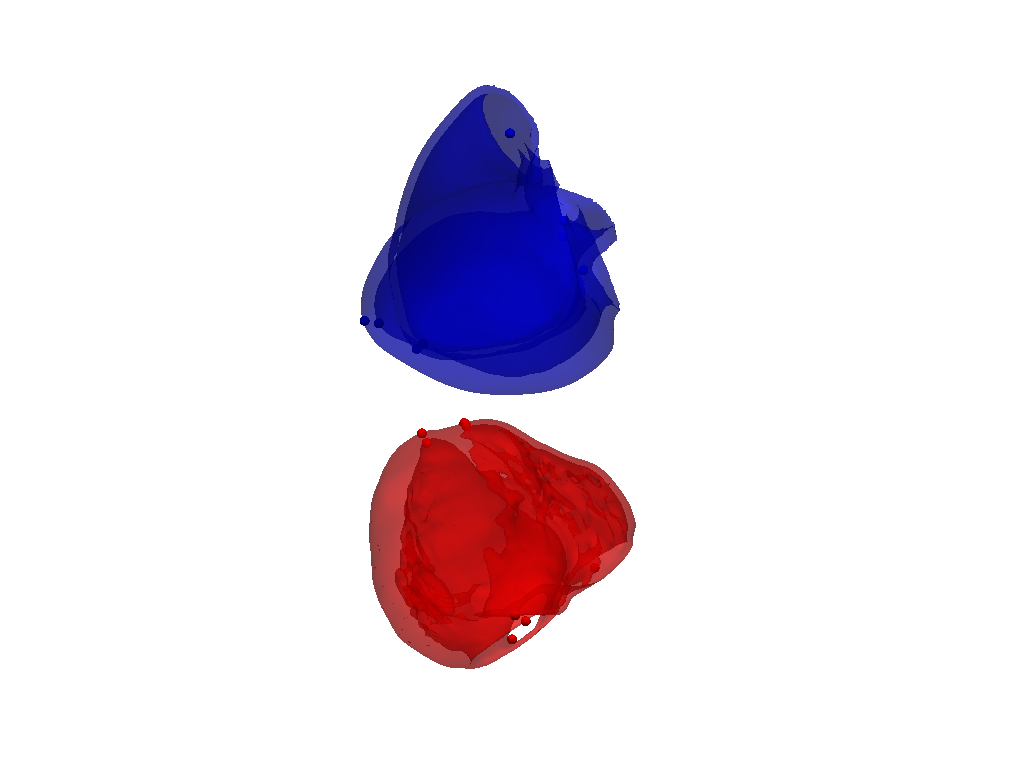

In [30]:
import pyvista as pv
from vtk import vtkLandmarkTransform, vtkPoints, vtkTransform

fix_cloud = pv.PolyData(fix_points)
move_cloud = pv.PolyData(move_points)

# p = pv.Plotter()
# p.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p.add_mesh(model.mesh, color="red", opacity=0.3)
# p.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p.add_mesh(heart, color="blue", opacity=0.3)
# p.show()

fix_vtk_points = vtkPoints()
for point in fix_cloud.points:
    fix_vtk_points.InsertNextPoint(point)

move_vtk_points = vtkPoints()
for point in transformed_move_cloud.points:
    move_vtk_points.InsertNextPoint(point)


"""
establish the mapping relationship between the two spaces
vtkLandmarkTransform facilitates mapping points 
between spaces based on 
user-defined landmark correspondences
"""
landmark_transform = vtkLandmarkTransform()
landmark_transform.SetSourceLandmarks(fix_vtk_points)
landmark_transform.SetTargetLandmarks(move_vtk_points)
landmark_transform.SetModeToSimilarity()
landmark_transform.Update()

matrix = landmark_transform.GetMatrix()

vtk_transform = vtkTransform()
vtk_transform.SetMatrix(matrix)

transformed_move_cloud = move_cloud.copy()
transformed_move_cloud.transform(vtk_transform)


moving_model = heart.copy()

moving_model.transform(vtk_transform)

p2 = pv.Plotter()

p2.add_mesh(fix_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(moving_model, color="red", opacity=0.5)
p2.add_mesh(model.mesh, color="blue", opacity=0.5)

p2.background_color = "white"

p2.show()

In [31]:
evaluate_mesh_similarity(moving_model,model)

Mean Surface Distance: 124.83661966396109
Hausdorff Distance: 123.79462083027082
Surface Overlap: 0.7154167367496989


# SetModeToAffine

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


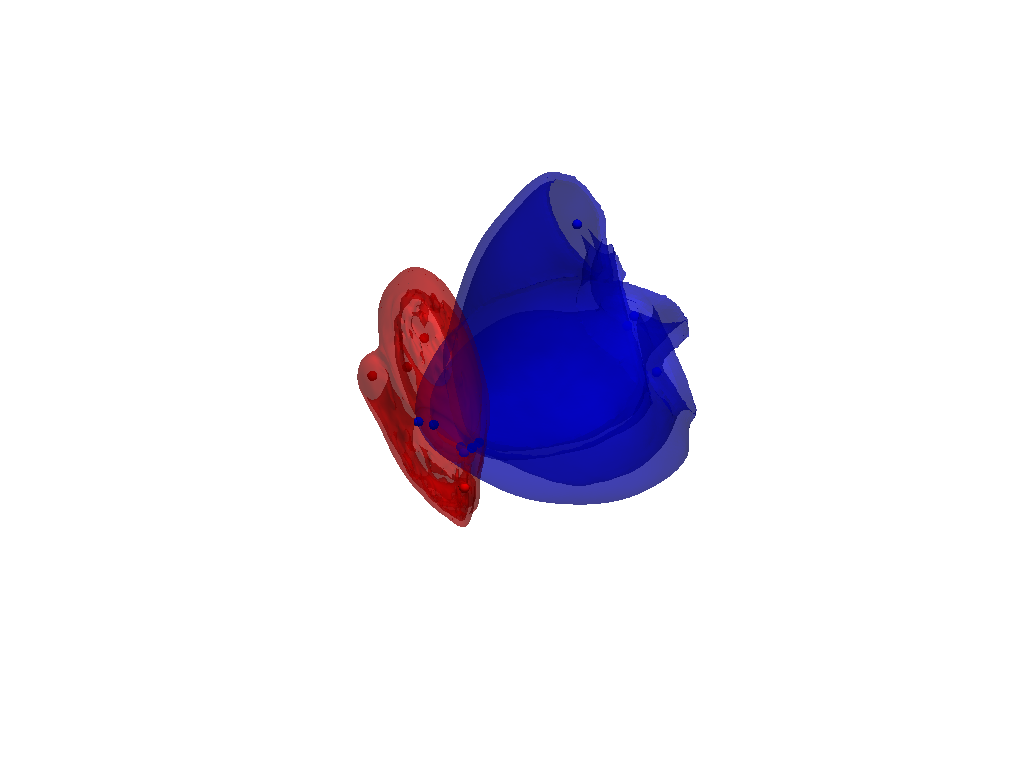

In [32]:
import pyvista as pv
from vtk import vtkLandmarkTransform, vtkPoints, vtkTransform

fix_cloud = pv.PolyData(fix_points)
move_cloud = pv.PolyData(move_points)

# p = pv.Plotter()
# p.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p.add_mesh(model.mesh, color="red", opacity=0.3)
# p.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p.add_mesh(heart, color="blue", opacity=0.3)
# p.show()

fix_vtk_points = vtkPoints()
for point in fix_cloud.points:
    fix_vtk_points.InsertNextPoint(point)

move_vtk_points = vtkPoints()
for point in transformed_move_cloud.points:
    move_vtk_points.InsertNextPoint(point)


"""
establish the mapping relationship between the two spaces
vtkLandmarkTransform facilitates mapping points 
between spaces based on 
user-defined landmark correspondences
"""
landmark_transform = vtkLandmarkTransform()
landmark_transform.SetSourceLandmarks(fix_vtk_points)
landmark_transform.SetTargetLandmarks(move_vtk_points)
landmark_transform.SetModeToAffine()
landmark_transform.Update()

matrix = landmark_transform.GetMatrix()

vtk_transform = vtkTransform()
vtk_transform.SetMatrix(matrix)

transformed_move_cloud = move_cloud.copy()
transformed_move_cloud.transform(vtk_transform)


moving_model = heart.copy()

moving_model.transform(vtk_transform)

p2 = pv.Plotter()

p2.add_mesh(fix_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(moving_model, color="red", opacity=0.5)
p2.add_mesh(model.mesh, color="blue", opacity=0.5)

p2.background_color = "white"

p2.show()

In [33]:
evaluate_mesh_similarity(moving_model,model)

Mean Surface Distance: 120.28754492015139
Hausdorff Distance: 95.94521030112485
Surface Overlap: 0.813673298208391


# Rigid transform with ICP -  cloud points


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


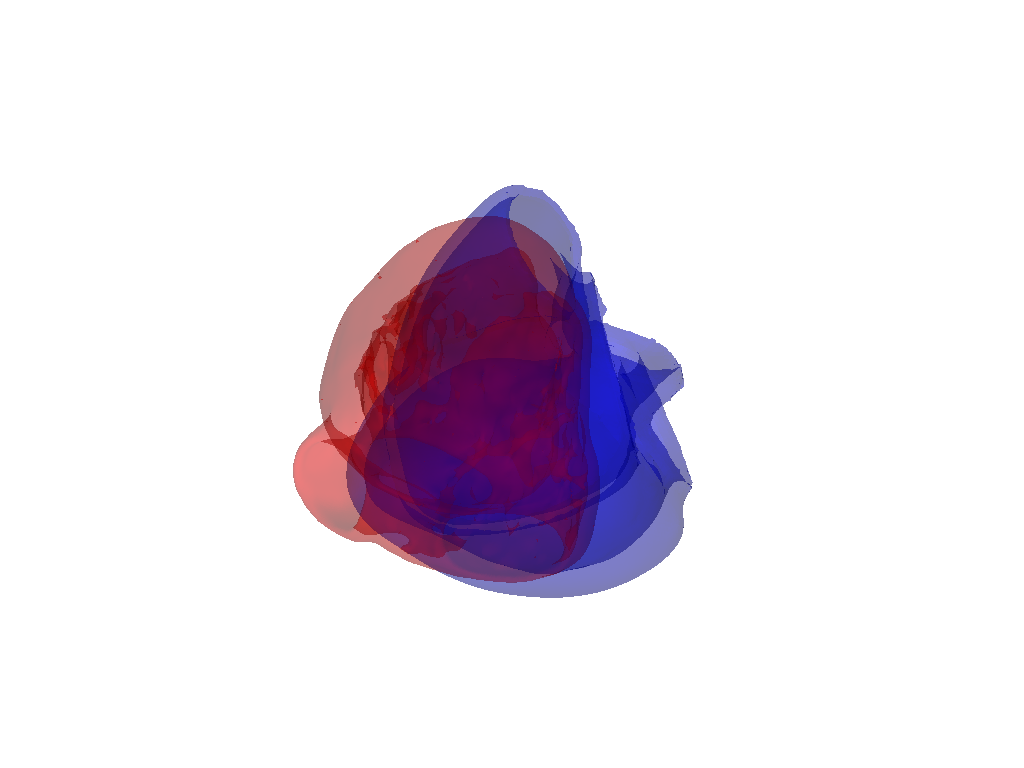

In [35]:
# moving_model = transformed_model.copy()
Source = move_cloud.copy() # moving model
Target = fix_cloud.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(Source)
icp.SetTarget(Target)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.0001)
icp.SetMaximumNumberOfIterations(1000)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()

model_h = heart.copy()
aligned = model_h.transform(icp.GetMatrix())

p2 = pyvista.Plotter()


# p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3) # orginal model
p2.add_mesh(aligned, color="red", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()


In [36]:
evaluate_mesh_similarity(aligned, model)

Mean Surface Distance: 63.718845342740515
Hausdorff Distance: 27.631837551773422
Surface Overlap: 0.9247181652103477


# Rigid transform with ICP -  mesh

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


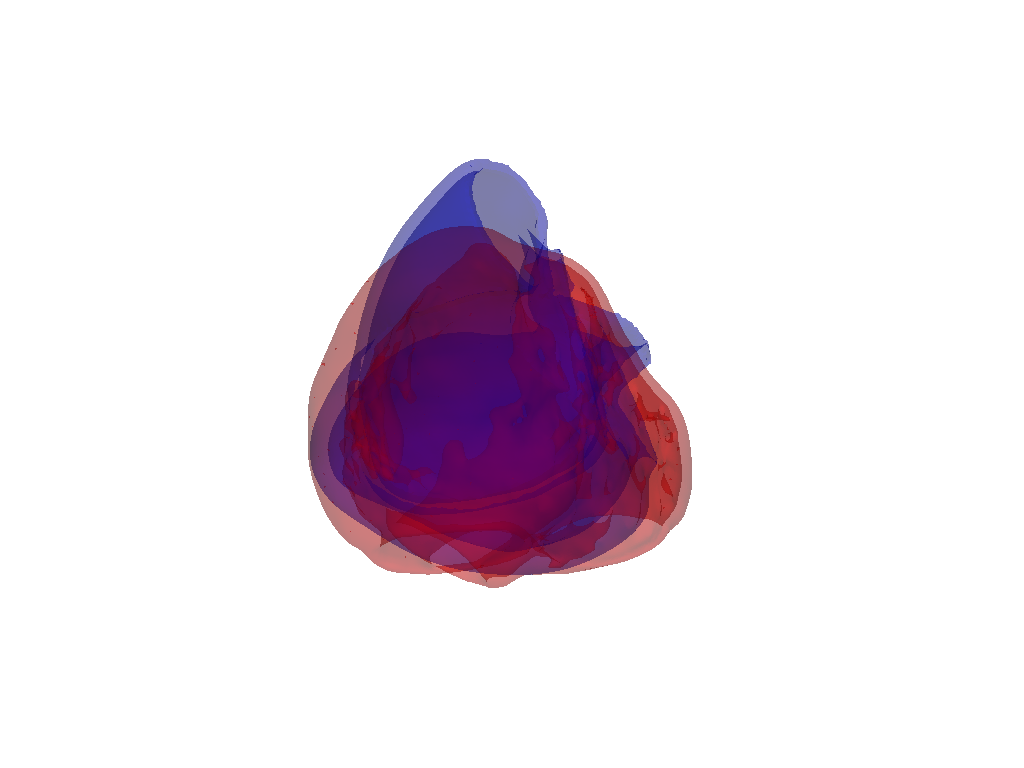

In [37]:
# moving_model = transformed_model.copy()
mesh_a = heart.copy() # moving model
mesh_b = model.mesh.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.0001)
icp.SetMaximumNumberOfIterations(1000)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()

model_h = heart.copy()
aligned = model_h.transform(icp.GetMatrix())

p2 = pyvista.Plotter()


# p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3) # orginal model
p2.add_mesh(aligned, color="red", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()


In [38]:
evaluate_mesh_similarity(aligned, model)

Mean Surface Distance: 63.65271618431155
Hausdorff Distance: 26.32036025777785
Surface Overlap: 0.9231384121214403


# scipy + ICP

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


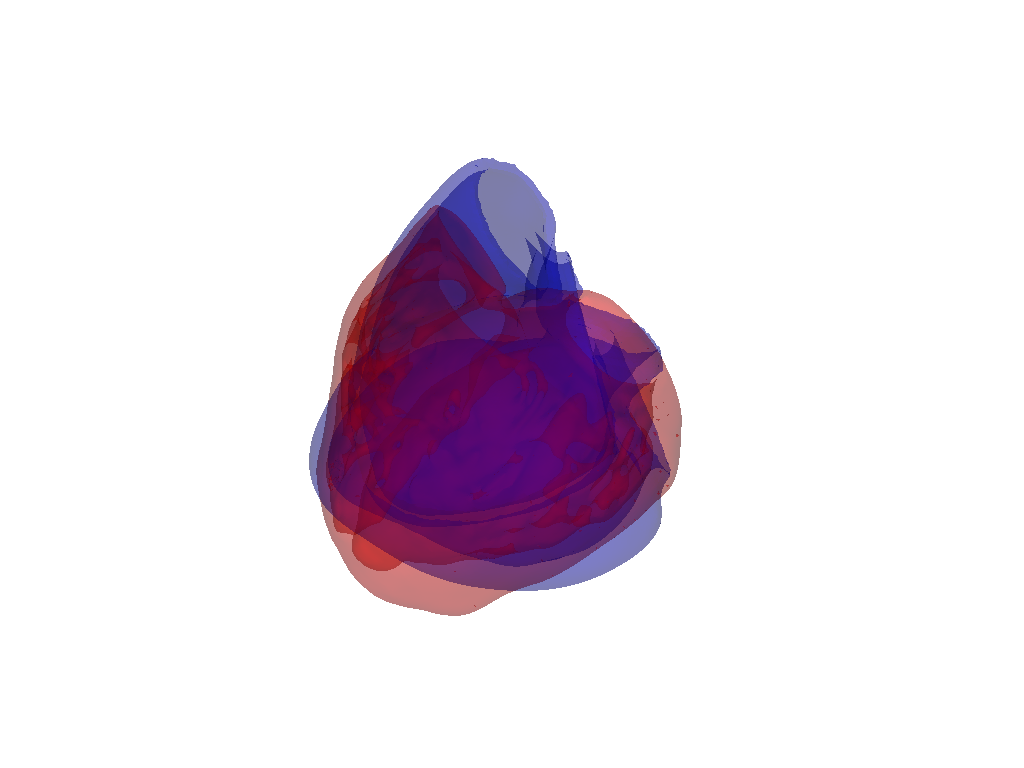

In [39]:
# moving_model = transformed_model.copy()
mesh_a = transformed_model.copy() # moving model
mesh_b = model.mesh.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.0001)
icp.SetMaximumNumberOfIterations(1000)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()


aligned = mesh_a.transform(icp.GetMatrix())

p2 = pyvista.Plotter()

# p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3) # orginal model
p2.add_mesh(aligned, color="red", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()


In [40]:
evaluate_mesh_similarity(aligned, model)

Mean Surface Distance: 62.289661114826906
Hausdorff Distance: 24.756765763917794
Surface Overlap: 0.9236068418840534


#### TEST: ICP with different number of landmarks, number of iterations...

In [ ]:
from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform

mesh_a = model.mesh
mesh_b = heart

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(10000)
icp.SetMaximumMeanDistance(.00001)
icp.SetMaximumNumberOfIterations(5000)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()

aligned = mesh_a.transform(icp.GetMatrix())


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


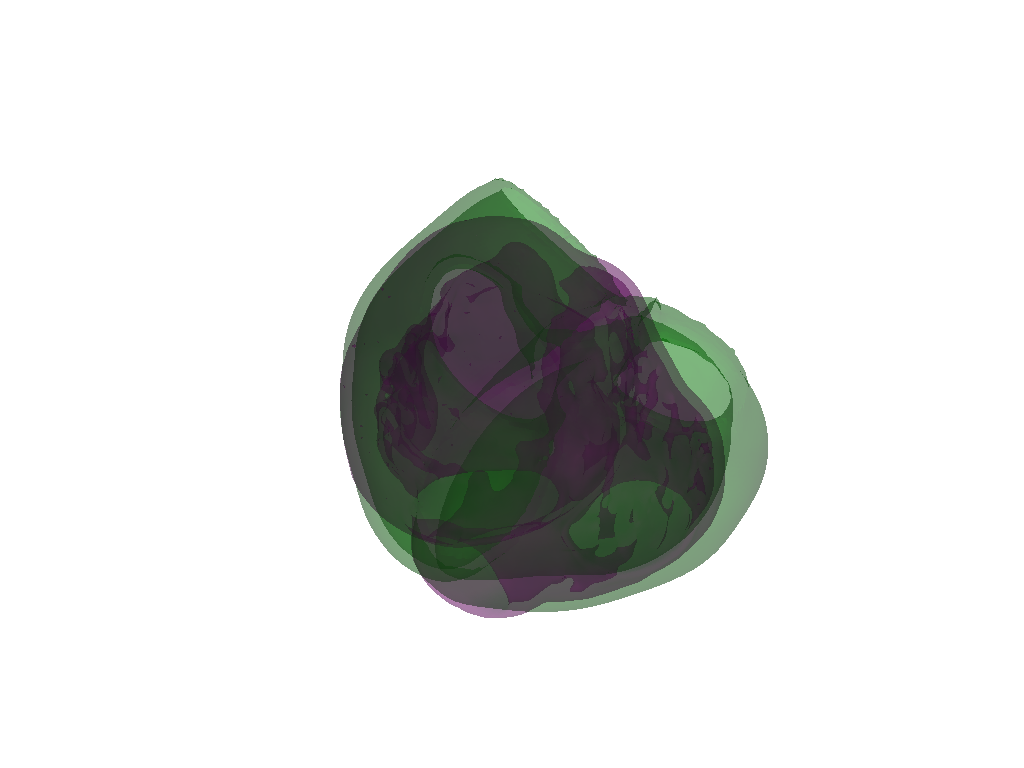

In [ ]:
p2 = pyvista.Plotter()

# Visualize the original moving model and the transformed model
# p2.add_mesh(model.mesh, color="green", opacity=0.1)
p2.add_mesh(mesh_b, color="purple", opacity=0.3)
p2.add_mesh(aligned, color="green", opacity=0.3)

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

In [ ]:
from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform

# fix_cloud = pv.PolyData(fix_points)
# move_cloud = pv.PolyData(move_points)

# mesh_a = fix_cloud.copy()
# mesh_b = move_cloud.copy()

mesh_a = model.mesh
mesh_b = heart

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)
icp.GetLandmarkTransform().SetModeToSimilarity()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(.00001)
icp.SetMaximumNumberOfIterations(500)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()

aligned = mesh_a.transform(icp.GetMatrix())


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


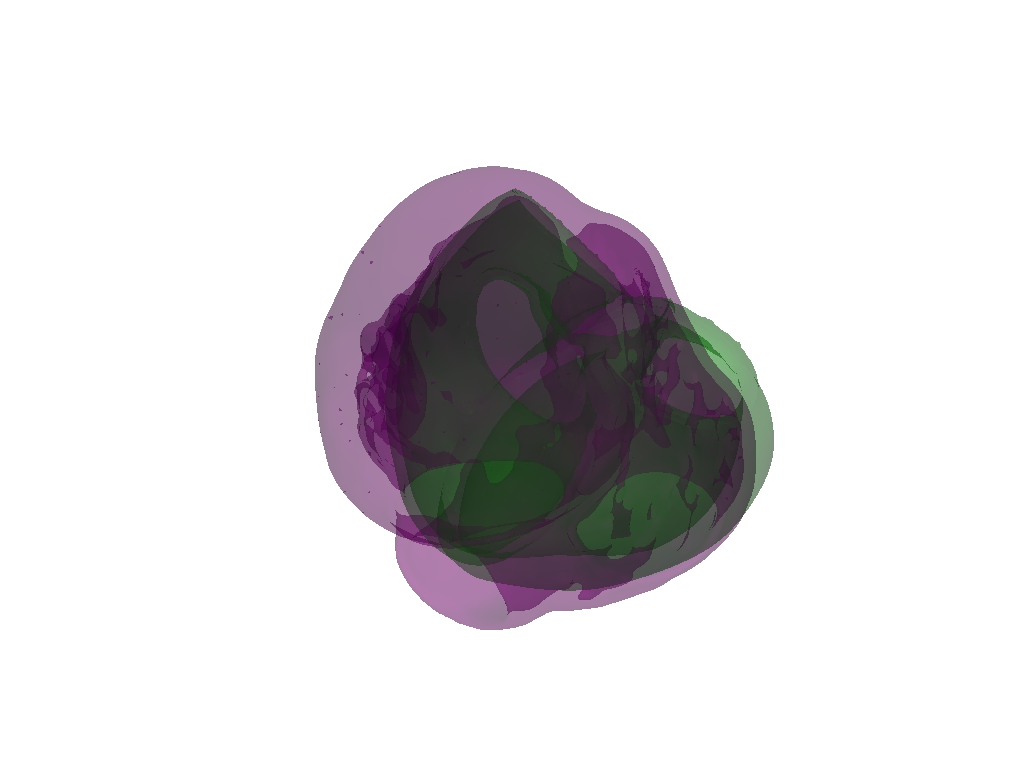

In [ ]:
p2 = pyvista.Plotter()

# Visualize the original moving model and the transformed model
# p2.add_mesh(model.mesh, color="green", opacity=0.1)
p2.add_mesh(mesh_b, color="purple", opacity=0.3)
p2.add_mesh(aligned, color="green", opacity=0.3)

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

In [ ]:
from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform

# fix_cloud = pv.PolyData(fix_points)
# move_cloud = pv.PolyData(move_points)

# mesh_a = fix_cloud.copy()
# mesh_b = move_cloud.copy()

mesh_a = model.mesh
mesh_b = heart

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)
icp.GetLandmarkTransform().SetModeToAffine()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(.00001)
icp.SetMaximumNumberOfIterations(500)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()

aligned = mesh_a.transform(icp.GetMatrix())


c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


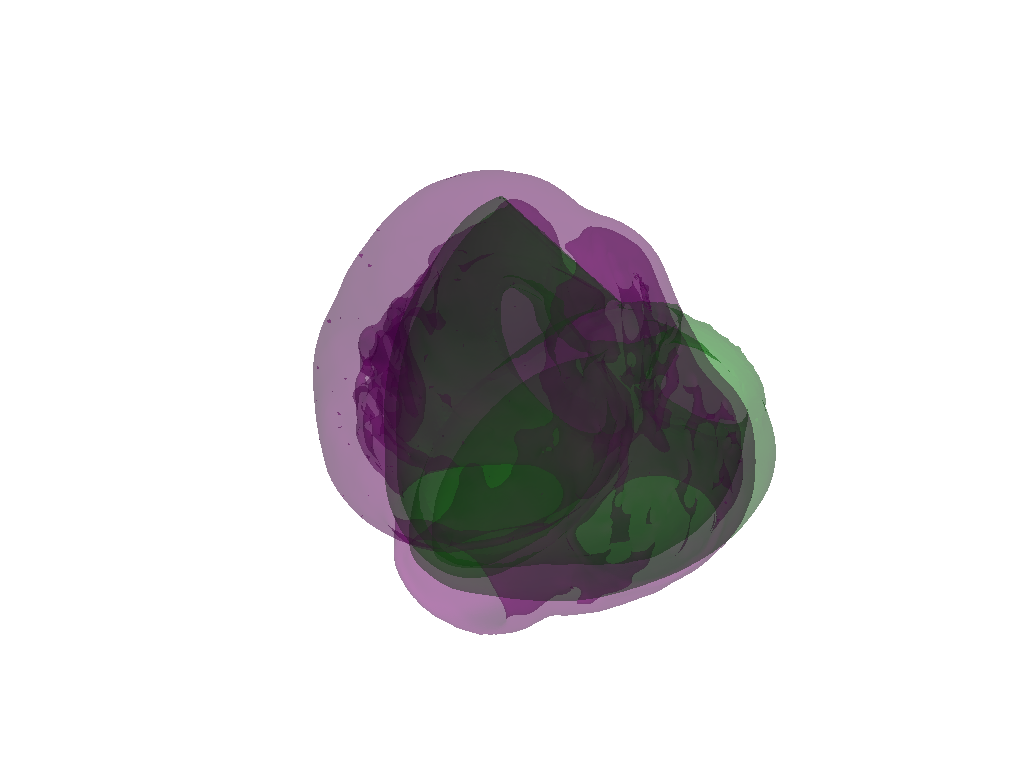

In [ ]:
p2 = pyvista.Plotter()

# Visualize the original moving model and the transformed model
# p2.add_mesh(model.mesh, color="green", opacity=0.1)
p2.add_mesh(mesh_b, color="purple", opacity=0.3)
p2.add_mesh(aligned, color="green", opacity=0.3)

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

In [41]:
import vtk

# moving_model = transformed_model.copy()


# p2 = pyvista.Plotter()
# p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)



mesh_a = transformed_move_cloud.copy() # moving model
mesh_b = fix_cloud.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.000001)
icp.SetMaximumNumberOfIterations(100)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()


transformation_matrix = icp.GetMatrix()

transform = vtk.vtkTransform()
transform.SetMatrix(transformation_matrix)
# Assuming trans_model is a PyVista UnstructuredGrid object
trans_model = transformed_model.copy()

# Create a PyVista transform object
vtk_transform = vtk.vtkTransform()
vtk_transform.SetMatrix(icp.GetMatrix())

# Apply the transformation to the PyVista mesh
trans_model.transform(vtk_transform)

# aligned = mesh_a.transform(icp.GetMatrix())

UnstructuredGrid (0x22e8d13ba60)
  N Cells:    2714010
  N Points:   709914
  X Bounds:   -9.960e+01, 9.053e+00
  Y Bounds:   1.372e+02, 2.368e+02
  Z Bounds:   3.622e+02, 4.661e+02
  N Arrays:   2

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


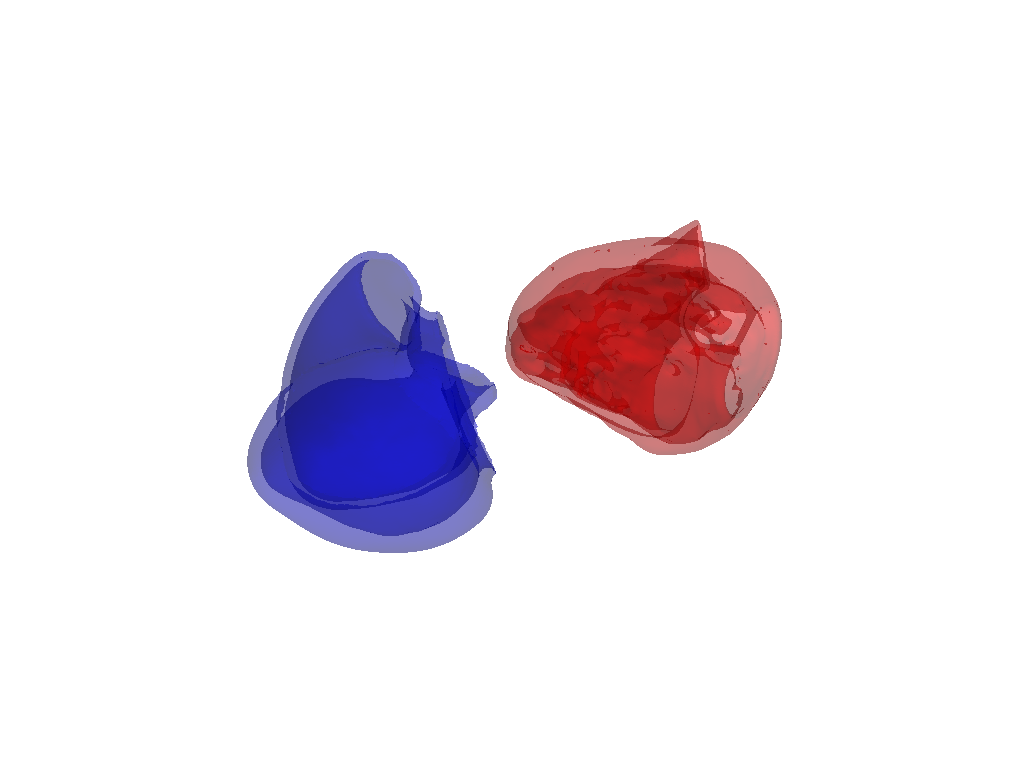

In [44]:
p2 = pyvista.Plotter()

p2.add_mesh(model.mesh, color="blue", opacity=0.3)
# p2.add_mesh(transformed_model, color="purple", opacity=0.3) # orginal model
p2.add_mesh(trans_model, color="red", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

In [45]:
evaluate_mesh_similarity(aligned, model)

Mean Surface Distance: 62.2427650732519
Hausdorff Distance: 24.521431743953933
Surface Overlap: 0.9235530948835656


### TEST: Registration without apex - rigid trans with scipy

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


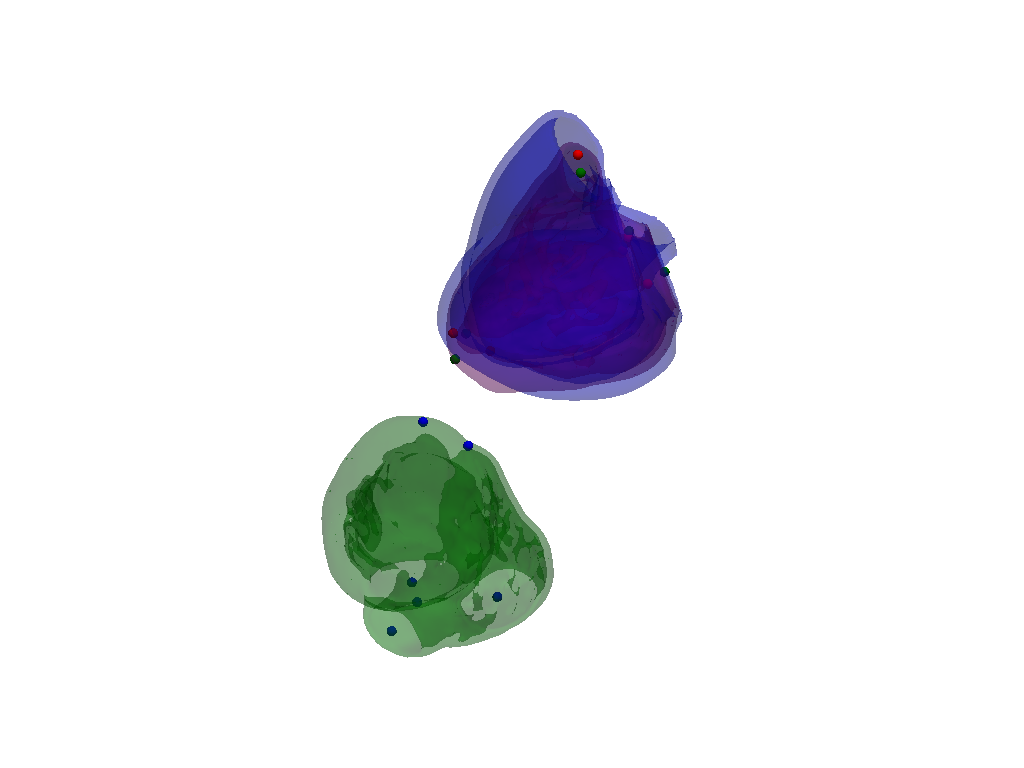

In [46]:
# --------------------------Use rigid transform--------------------------

fix_points = np.array([
    [14.83343254, 138.84328635, 381.69040887],
    [4.05351488, 118.41811815, 391.29761896],
    [-23.05345085, 92.81499077, 363.12556701],
    [12.11718736, 95.61561885, 424.1137484],
    [66.62810203, 76.12861982, 352.41549411],
    [45.85018296, 77.32545243, 333.88303795],
])

move_points = np.array([
    [81.90321388, 57.90000882, 205.76663367],
    [94.35242091, 75.99022315, 213.31654731],
    [67.14045655, 102.49380179, 216.20654707],
    [121.58912558, 89.76497459, 223.29557159],
    [67.23725112873248, 84.63169515538843, 296.5102709741695],
    [74.54353173118157, 63.020954005473115, 302.25073384261583],
])

moving_model = heart

# Define the initial transformation parameters
random_quaternion = Rotation.random().as_quat()
initial_params = np.zeros(7)
initial_params[:3] = np.random.rand(3)  # Random translation
initial_params[3:] = random_quaternion

# Constrain quaternion components to ensure they remain valid
constraints = ({'type': 'eq', 'fun': lambda params: 1.0 - np.sum(params[3:] ** 2)})

# Define the rigid transform function
def rigid_transform(params, points):
    translation = params[:3]
    quaternion = params[3:]
    quaternion /= np.linalg.norm(quaternion)
    rotation_matrix = Rotation.from_quat(quaternion).as_matrix()
    transformed_points = np.dot(points - translation, rotation_matrix.T)
    return transformed_points

# Define the objective function
def objective_function(params, fixed_points, moving_points):
    transformed_points = rigid_transform(params, moving_points)
    distance = np.sum(np.square(transformed_points - fixed_points))
    return distance

result = minimize(objective_function, initial_params, args=(fix_points, move_points), method='L-BFGS-B', constraints=constraints)

optimal_params = result.x

# Get rigidly transformed moving model point cloud
transformed_move_points = rigid_transform(optimal_params, move_points)

# Create PyVista point cloud objects
fix_cloud = pyvista.PolyData(fix_points)
move_cloud = pyvista.PolyData(move_points)
transformed_move_cloud = pyvista.PolyData(transformed_move_points)

# Show fixed and moving models and aligned models
p2 = pyvista.Plotter()
p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)

# Get the optimized parameters
optimal_params = result.x

# Apply the optimal transformation to the moving model
transformed_model = moving_model.copy()
transformed_model.points = rigid_transform(optimal_params, moving_model.points)

# Visualize the original moving model and the transformed model
p2.add_mesh(moving_model, color="green", opacity=0.3)
p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3)



# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

### TEST: Registration without apex - landmark

In [47]:
import vtk

# moving_model = transformed_model.copy()


# p2 = pyvista.Plotter()
# p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)



mesh_a = transformed_move_cloud.copy() # moving model
mesh_b = fix_cloud.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.0001)
icp.SetMaximumNumberOfIterations(100)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()


# Get the transformation matrix
transformation_matrix = icp.GetMatrix()

# Create the vtkTransform object and apply the transformation
transform = vtk.vtkTransform()
transform.SetMatrix(transformation_matrix)
# Assuming trans_model is a PyVista UnstructuredGrid object
trans_model = transformed_model.copy()

# Create a PyVista transform object
vtk_transform = vtk.vtkTransform()
vtk_transform.SetMatrix(icp.GetMatrix())

# Apply the transformation to the PyVista mesh
trans_model.transform(vtk_transform)

# aligned = mesh_a.transform(icp.GetMatrix())




UnstructuredGrid (0x22e8d13b5e0)
  N Cells:    2714010
  N Points:   709914
  X Bounds:   -3.165e+01, 8.074e+01
  Y Bounds:   5.854e+01, 1.586e+02
  Z Bounds:   3.325e+02, 4.260e+02
  N Arrays:   2

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


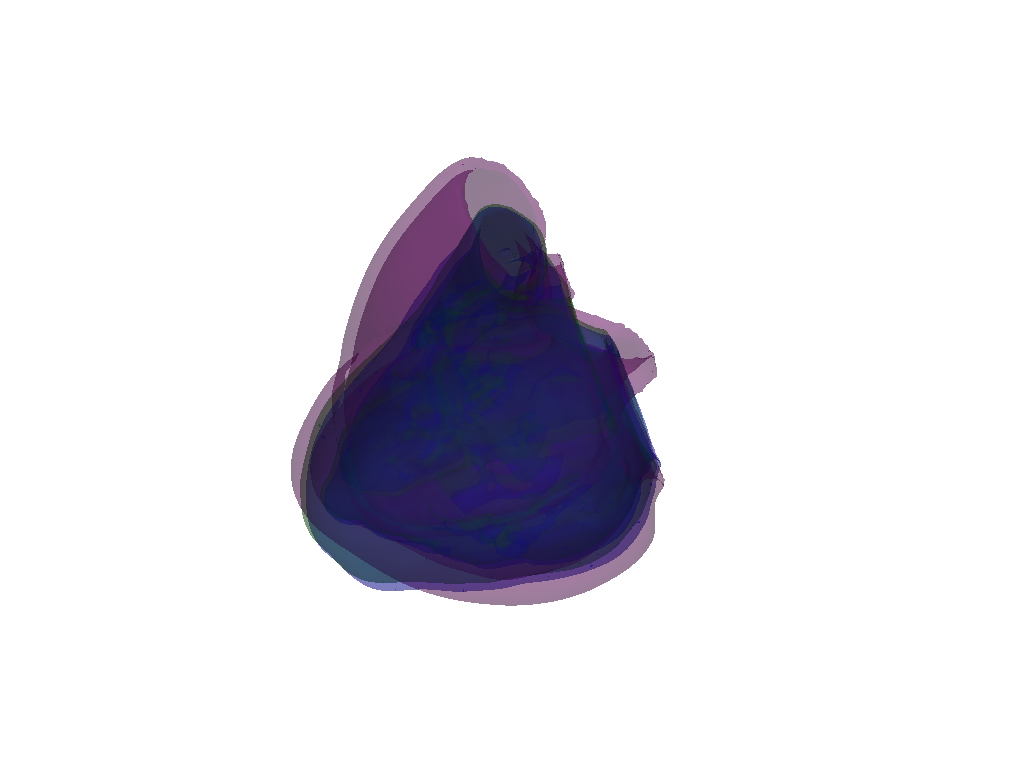

In [48]:
p2 = pyvista.Plotter()

p2.add_mesh(model.mesh, color="purple", opacity=0.3)
p2.add_mesh(transformed_model, color="blue", opacity=0.3) # orginal model
p2.add_mesh(trans_model, color="green", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

# Conclusion
Chose rigid trans first for now and applied on electrodes

In [51]:
# p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)

# Get the optimized parameters
optimal_params = result.x

# Apply the optimal transformation to the moving model
transformed_model = moving_model.copy()
transformed_model.points = rigid_transform(optimal_params, moving_model.points)

electrode_positions = np.array([
    [x, y, z] for x, y, z in [
        [91.69106809237354, 167.4055272828183, 251.0416838617331],  # V1
        [114.07772933063883, 123.13918227704727, 291.5674747053013],  # V2
        [97.01364431022192, 109.7927312489943, 317.44575378942824],  # V3
        [81.88880486815538, 71.3859176743268, 349.4243690358569],  # V4
        [98.99550734014053, 15.879947224122954, 348.26233938958114],  # V5
        [106.23537044908527, -44.085603837273695, 329.16199248487465],  # V6
        [170.75567690191764, 234.51300755277248, 77.85629801985534],  # RA
        [262.9539413249434, -2.9189733795951724, 261.5745131716608],  # LA
        [-134.9640236606803, 197.05542132895272, 257.6409644703581],  # RL
        [-70.4506948627224, 22.20437217827933, 400.2792599184596]  # LL
    ]
])

transformed_electrodes = rigid_transform(optimal_params, electrode_positions)

c:\ProgramData\miniforge3\envs\env38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


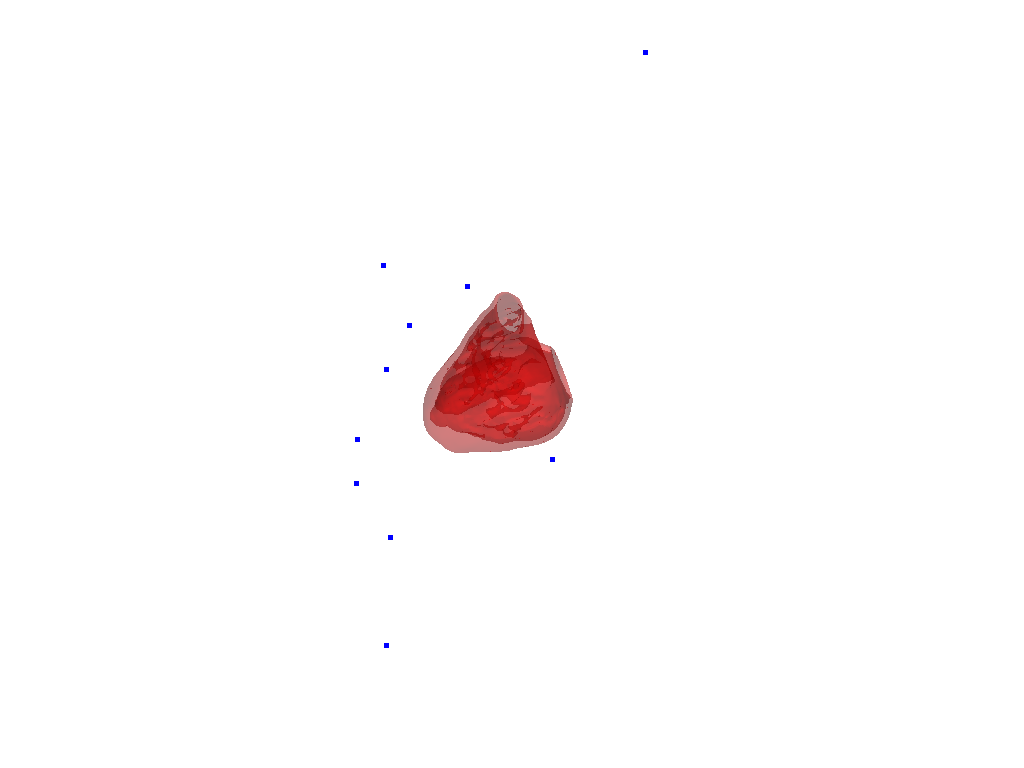

In [52]:
plotter=pyvista.Plotter()

plotter.add_mesh(transformed_model, color="red", opacity=0.3)
# p2.add_mesh(model.mesh, color="blue", opacity=0.3)
plotter.add_mesh(transformed_electrodes, color="blue", opacity=1)
# p2.add_mesh(electrode_positions, color="red", opacity=1)

plotter.background_color = "white"
plotter.show()